In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="https://developer.download.nvidia.com/tesla/notebook_assets/nv_logo_torch_trt_resnet_notebook.png" style="width: 90px; float: right;">

# Torch-TensorRT Getting Started - ResNet 50

## Overview

In the practice of developing machine learning models, there are few tools as approachable as PyTorch for developing and experimenting in designing machine learning models. The power of PyTorch comes from its deep integration into Python, its flexibility and its approach to automatic differentiation and execution (eager execution). However, when moving from research into production, the requirements change and we may no longer want that deep Python integration and we want optimization to get the best performance we can on our deployment platform. In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable. TorchScript uses PyTorch's JIT compiler to transform your normal PyTorch code which gets interpreted by the Python interpreter to an intermediate representation (IR) which can have optimizations run on it and at runtime can get interpreted by the PyTorch JIT interpreter. For PyTorch this has opened up a whole new world of possibilities, including deployment in other languages like C++. It also introduces a structured graph based format that we can use to do down to the kernel level optimization of models for inference.

When deploying on NVIDIA GPUs TensorRT, NVIDIA's Deep Learning Optimization SDK and Runtime is able to take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family be it an A100, TITAN V, Jetson Xavier or NVIDIA's Deep Learning Accelerator. TensorRT performs a couple sets of optimizations to achieve this. TensorRT fuses layers and tensors in the model graph, it then uses a large kernel library to select implementations that perform best on the target GPU. TensorRT also has strong support for reduced operating precision execution which allows users to leverage the Tensor Cores on Volta and newer GPUs as well as reducing memory and computation footprints on device.

Torch-TensorRT is a compiler that uses TensorRT to optimize TorchScript code, compiling standard TorchScript modules into ones that internally run with TensorRT optimizations. This enables you to continue to remain in the PyTorch ecosystem, using all the great features PyTorch has such as module composability, its flexible tensor implementation, data loaders and more. Torch-TensorRT is available to use with both PyTorch and LibTorch.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with Torch-TensorRT on a pretrained ResNet-50 network, and running it to test the speedup obtained.

## Content
1. [Requirements](#1)
1. [ResNet-50 Overview](#2)
1. [Running the model without optimizations](#3)
1. [Accelerating with Torch-TensorRT](#4)
1. [Conclusion](#5)

In [2]:
!nvidia-smi
!pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

Tue Feb  8 19:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0 Off |                  N/A |
| 30%   29C    P8    15W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id="1"></a>
## 1. Requirements

NVIDIA's NGC provides PyTorch Docker Container which contains PyTorch and Torch-TensorRT. We can make use of [latest pytorch](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch) container to run this notebook.

Otherwise, you can follow the steps in `notebooks/README` to prepare a Docker container yourself, within which you can run this demo notebook.

<a id="2"></a>
## 2. ResNet-50 Overview


PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our ResNet-50 model from there pretrained on ImageNet.

### Model Description

This ResNet-50 model is based on the [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) paper, which describes ResNet as “a method for detecting objects in images using a single deep neural network". The input size is fixed to 32x32.

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>




<a id="3"></a>
## 3. Running the model without optimizations


PyTorch has a model repository called `timm`, which is a source for high quality implementations of computer vision models. We can get our EfficientNet model from there pretrained on ImageNet.

In [3]:
import torch
import torchvision

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

With our model loaded, let's proceed to downloading some images!

In [4]:
!mkdir -p ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

--2022-02-08 19:17:19--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 18.65.227.99, 18.65.227.37, 18.65.227.223, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|18.65.227.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.002s  

2022-02-08 19:17:19 (14.6 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2022-02-08 19:17:19--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452718 (442K) [image/jpeg]
Saving to: ‘./data/img1.J

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least `224`.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

Here's a sample execution.

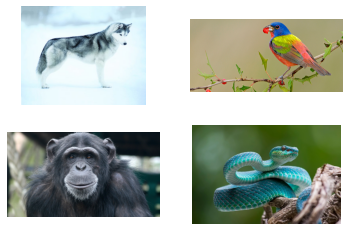

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json 

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)      
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')

# loading labels    
with open("./data/imagenet_class_index.json") as json_file: 
    d = json.load(json_file)

Throughout this tutorial, we will be making use of some utility functions; `rn50_preprocess` for preprocessing input images, `predict` to use the model for prediction and `benchmark` to benchmark the inference. You do not need to understand/go through these utilities to make use of Torch TensorRT, but are welecomed to do so if you choose.

In [6]:
import numpy as np
import time
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

# decode the results into ([predicted class, description], probability)
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        sm_output = torch.nn.functional.softmax(output[0], dim=0)
        
    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] #([predicted class, description], probability)

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

With the model downloaded and the util functions written, let's just quickly see some predictions, and benchmark the model in its current un-optimized state.

./data/img0.JPG - Predicted: ['n02110185', 'Siberian_husky'], Probablility: 0.49785590171813965
./data/img1.JPG - Predicted: ['n01820546', 'lorikeet'], Probablility: 0.6445754766464233
./data/img2.JPG - Predicted: ['n02481823', 'chimpanzee'], Probablility: 0.9899807572364807
./data/img3.JPG - Predicted: ['n01749939', 'green_mamba'], Probablility: 0.39485082030296326


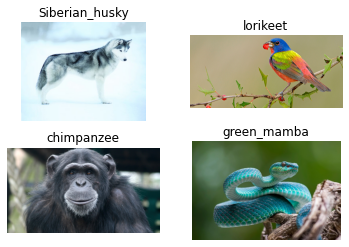

In [7]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    
    pred, prob = predict(img_path, resnet50_model)
    print('{} - Predicted: {}, Probablility: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(pred[1])

In [8]:
# Model benchmark without Torch-TensorRT
model = resnet50_model.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 75.34 ms
Iteration 20/100, ave batch time 75.33 ms
Iteration 30/100, ave batch time 75.35 ms
Iteration 40/100, ave batch time 75.37 ms
Iteration 50/100, ave batch time 75.38 ms
Iteration 60/100, ave batch time 75.38 ms
Iteration 70/100, ave batch time 75.39 ms
Iteration 80/100, ave batch time 75.39 ms
Iteration 90/100, ave batch time 75.40 ms
Iteration 100/100, ave batch time 75.41 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 75.41 ms


<a id="4"></a>
## 4. Accelerating with Torch-TensorRT

Onwards to the next step, accelerating with Torch TensorRT. In these examples we showcase the results for FP32 (single precision) and FP16 (half precision). We do not demonstrat specific tuning, just showcase the simplicity of usage. If you want to learn more about the possible customizations, visit our [documentation](https://nvidia.github.io/Torch-TensorRT/).

### FP32 (single precision)

In [9]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp32 = torch_tensorrt.compile(model, inputs = [torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = torch.float32, # Run with FP32
    workspace_size = 1 << 22
)

In [10]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp32, input_shape=(128, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 41.02 ms
Iteration 20/100, ave batch time 41.12 ms
Iteration 30/100, ave batch time 41.22 ms
Iteration 40/100, ave batch time 41.14 ms
Iteration 50/100, ave batch time 41.20 ms
Iteration 60/100, ave batch time 41.20 ms
Iteration 70/100, ave batch time 41.19 ms
Iteration 80/100, ave batch time 41.23 ms
Iteration 90/100, ave batch time 41.20 ms
Iteration 100/100, ave batch time 41.21 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 41.21 ms


### FP16 (half precision)

In [11]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model_fp16 = torch_tensorrt.compile(model, inputs = [torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.half)],
    enabled_precisions = {torch.half}, # Run with FP32
    workspace_size = 1 << 22
)


The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


In [13]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp16, input_shape=(128, 3, 224, 224), dtype='fp16', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 14.48 ms
Iteration 20/100, ave batch time 14.58 ms
Iteration 30/100, ave batch time 14.72 ms
Iteration 40/100, ave batch time 14.73 ms
Iteration 50/100, ave batch time 14.70 ms
Iteration 60/100, ave batch time 14.79 ms
Iteration 70/100, ave batch time 14.73 ms
Iteration 80/100, ave batch time 14.69 ms
Iteration 90/100, ave batch time 14.68 ms
Iteration 100/100, ave batch time 14.69 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 14.69 ms


<a id="5"></a>
## 5. Conclusion

In this notebook, we have walked through the complete process of compiling TorchScript models with Torch-TensorRT for EfficientNet-B0 model and test the performance impact of the optimization. With Torch-TensorRT, we observe a speedup of **1.84x** with FP32, and **5.2x** with FP16 on an NVIDIA 3090 GPU. These acceleration numbers will vary from GPU to GPU(as well as implementation to implementation based on the ops used) and we encorage you to try out latest generation of Data center compute cards for maximum acceleration.

### What's next
Now it's time to try Torch-TensorRT on your own model. If you run into any issues, you can fill them at https://github.com/NVIDIA/Torch-TensorRT. Your involvement will help future development of Torch-TensorRT.
